## Load and Preprocess

In [20]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [21]:
# Creates a random seed
import time
import random as rand

KERAS_SEED = int(rand.random() * time.time())
print("Seed:", KERAS_SEED)

Seed: 1556202785


In [22]:
# Read an image for size
img = cv.imread("../asl_alphabet_train/A/A1.jpg")
image_shape = img.shape

# Creates the batch size
BATCH_SIZE = 16

# Prints the image shape
image_shape

(200, 200, 3)

In [23]:
from keras import utils

# Identify the training, test, and validity data
train_data = utils.image_dataset_from_directory(
    "../asl_alphabet_data/train/",
    seed = KERAS_SEED,
    image_size = image_shape[:2],
    batch_size = BATCH_SIZE
)

val_data = utils.image_dataset_from_directory(
    "../asl_alphabet_data/val/",
    seed = KERAS_SEED,
    image_size = image_shape[:2],
    batch_size = BATCH_SIZE
)

test_data = utils.image_dataset_from_directory(
    "../asl_alphabet_data/test/",
    seed = KERAS_SEED,
    image_size = image_shape[:2],
    batch_size = BATCH_SIZE
)

class_names = train_data.class_names
print(class_names)

Found 69600 files belonging to 29 classes.
Found 13050 files belonging to 29 classes.
Found 4350 files belonging to 29 classes.
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


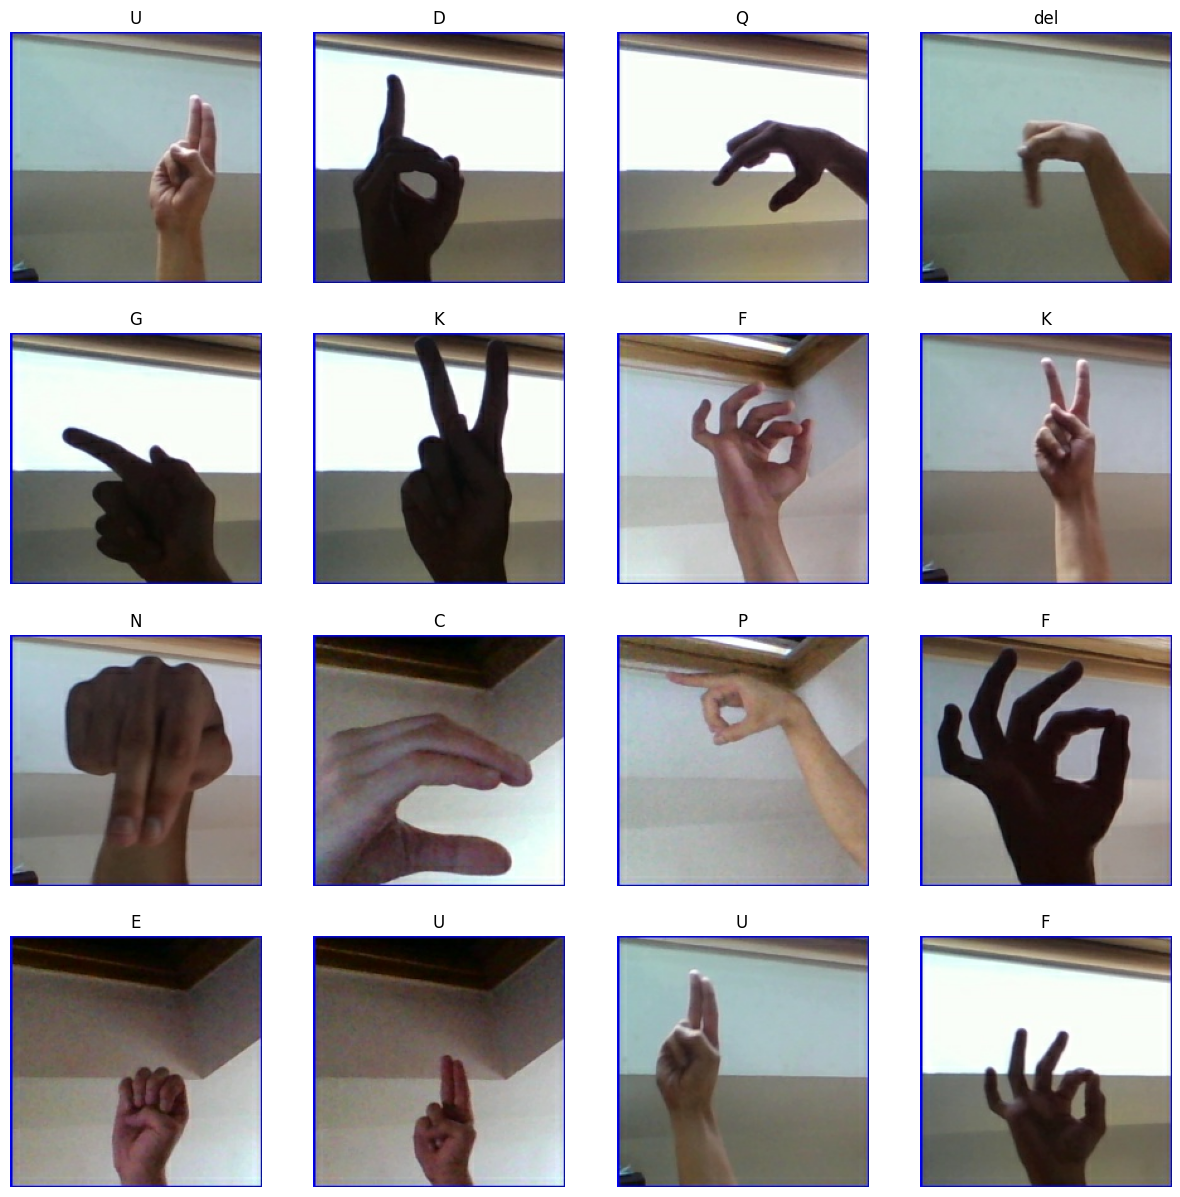

In [24]:
plt.figure(figsize = (15, 15))

for images, labels in train_data.take(1):
    for i in range(0, 16):
        plt.subplot(4, 4, i + 1)

        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Create the CNN

In [25]:
from keras import models
from keras import layers
from keras import applications
from keras.applications import vgg19

In [26]:
cnn = models.Sequential(
    [
        layers.Input(shape = image_shape),
        #applications.InceptionV3(include_top = False, input_shape = image_shape, classifier_activation = None),
        #vgg19.preprocess_input(),
        applications.VGG19(include_top = False, input_shape = image_shape, classifier_activation = None),
        layers.Flatten(),
        layers.Dense(len(class_names), activation = "softmax")
    ],
    name = "CNN"
)
cnn.layers[0].trainable = False

cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 6, 6, 512)         20024384  
                                                                 
 flatten_3 (Flatten)         (None, 18432)             0         
                                                                 
 dense_5 (Dense)             (None, 29)                534557    
                                                                 
Total params: 20,558,941
Trainable params: 534,557
Non-trainable params: 20,024,384
_________________________________________________________________


In [27]:
inputs = layers.Input(shape = image_shape)
#x = layers.Reshape(target_shape = (244, 244, 3))(inputs)
x = vgg19.preprocess_input(inputs)
x = applications.VGG19(include_top = False, input_shape = image_shape, classifier_activation = None)(x)
x = layers.Flatten()(x)
x = layers.Dense(2 * len(class_names), activation = "relu")(x)
outputs = layers.Dense(len(class_names), activation = "softmax")(x)

model = models.Model(inputs = inputs, outputs = outputs, name = "Ameri_Sign_Model")
model.layers[3].trainable = False

model.summary()

Model: "Ameri_Sign_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 200, 200, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 200, 200, 3)      0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, 6, 6, 512)         20024384  
                                                                 
 flatten_4 (Flatten)         (None, 18432)             0         
                                                                 
 dense_6 (Dense)             (None, 58)           

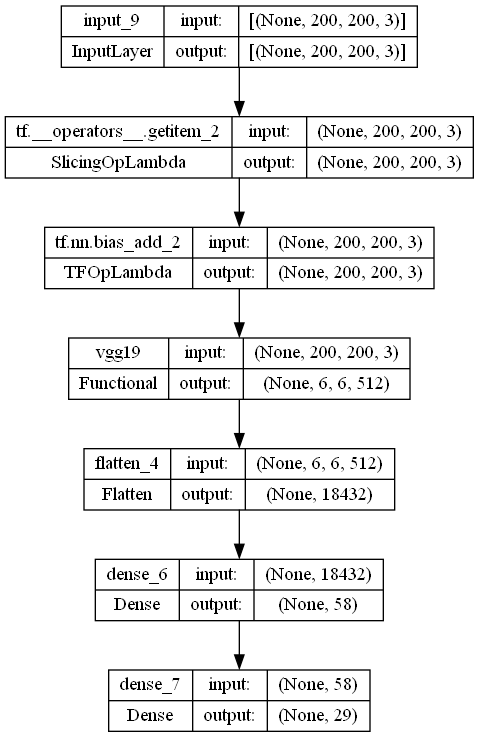

In [28]:
tf.keras.utils.plot_model(model, show_shapes = True)

## Train the CNN

In [29]:
from keras import losses
from keras import callbacks
from keras import optimizers

# Defines the optimizer
customOptimizer = optimizers.Adam(learning_rate = 5e-4)

# Defines the loss function
customLoss      = losses.SparseCategoricalCrossentropy()

# Defines the callbacks to include
my_callbacks = [
    #callbacks.ModelCheckpoint(filepath = "./Ameri Sign Models/Accuracy/mnist_detection.acc.{epoch:02d}-{val_accuracy:.2f}.h5", monitor = "val_accuracy", mode = "max", save_best_only = True),
    #callbacks.ModelCheckpoint(filepath = "./Ameri Sign Models/Loss/mnist_detection.loss.{epoch:02d}-{val_loss:.2f}.h5", monitor = "val_loss", mode = "min", save_best_only = True),
    callbacks.EarlyStopping  (patience = 5, monitor = "accuracy"),
    #callbacks.TensorBoard    (log_dir  = "./Logs")
]

# Compile the model
model.compile(optimizer = customOptimizer, loss = customLoss, metrics = ["accuracy"],  jit_compile = None)

In [30]:
# Trains the model
history = model.fit(train_data, epochs = 100, batch_size = 16, validation_data = val_data, callbacks = my_callbacks, use_multiprocessing = True)

## Evaluate the CNN

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [32]:
def plot_history(history):
    """
    Plotting training and validation learning curves.
    @param history: model history with all the metric measures
    """
    fig, (ax1, ax2) = plt.subplots(2)

    fig.set_size_inches(18.5, 10.5)

    # Plot loss
    ax1.set_title("Loss")
    ax1.plot(history.history["loss"], label = "train")
    ax1.plot(history.history["val_loss"], label = "test")
    ax1.set_ylabel("Loss")

    # Determine upper bound of y-axis
    max_loss = max(history.history["loss"] + history.history["val_loss"])

    ax1.set_ylim([0, np.ceil(max_loss)])
    ax1.set_xlabel("Epoch")
    ax1.legend(["Train", "Validation"]) 

    # Plot accuracy
    ax2.set_title("Accuracy")
    ax2.plot(history.history["accuracy"],  label = "train")
    ax2.plot(history.history["val_accuracy"], label = "test")
    ax2.set_ylabel("Accuracy")
    ax2.set_ylim([0, 1])
    ax2.set_xlabel("Epoch")
    ax2.legend(["Train", "Validation"])

    plt.show()

In [33]:
def get_actual_predicted_labels(dataset): 
    """
    Creates a list of actual ground truth values and the predictions from the model.
    @param dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.
    @return Ground truth and predicted values for a particular dataset.
    """
    actual = []
    for _, labels in dataset:
        for ind in labels:
            actual.append(class_names[ind])

    predicted = model.predict(dataset)

    pred = []
    for labels in predicted:
        ind = tf.argmax(labels, axis = 0)
        pred.append(class_names[ind])

    return actual, pred

In [34]:
def plot_confusion_matrix(actual, predicted, labels):
    """
    Plots the confusion matrix.
    """
    matrix = confusion_matrix(y_true = actual, y_pred = predicted, labels = labels)
    disp = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = labels)
    disp.plot()
    plt.show()

In [35]:
def calculate_classification_metrics(y_actual, y_pred, labels):
    """
    Calculate the precision and recall of a classification model using the ground truth and predicted values.
    @param y_actual: Ground truth labels.
    @param y_pred: Predicted labels.
    @param labels: List of classification labels.
    @return Precision and recall measures.
    """
    cm = tf.math.confusion_matrix(y_actual, y_pred)
    tp = np.diag(cm) # Diagonal represents true positives
    precision = dict()
    recall = dict()
    for i in range(len(labels)):
        col = cm[:, i]
        fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

        row = cm[i, :]
        fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

        precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 

        recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

    return precision, recall

In [37]:
# Plot learning Curves
plot_history(history)

In [38]:
trainActual, trainPredicted = get_actual_predicted_labels(train_data)

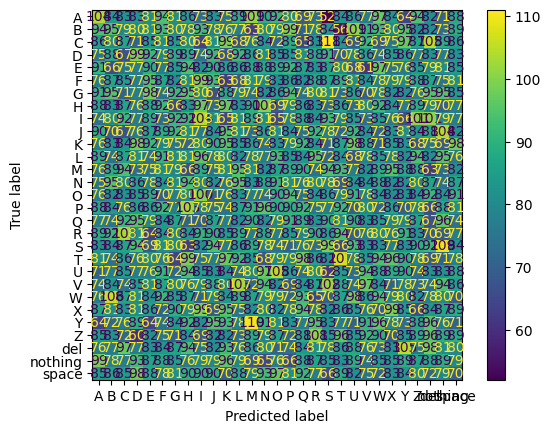

In [ ]:
plot_confusion_matrix(trainActual, trainPredicted, class_names)

In [ ]:
testActual, testPredicted = get_actual_predicted_labels(test_data)

272/272 [==============================] - 245s 902ms/step


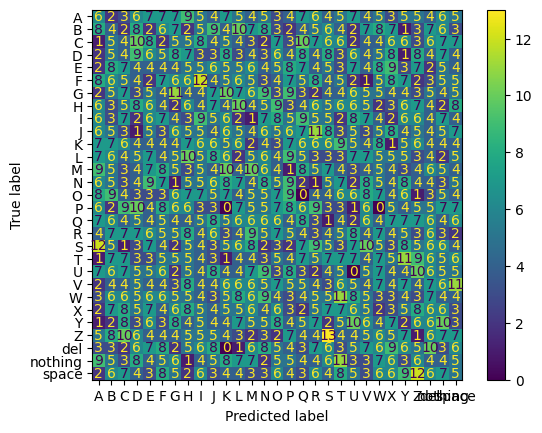

In [ ]:
plot_confusion_matrix(testActual, testPredicted, class_names)

In [ ]:
precision, recall = calculate_classification_metrics(testActual, testPredicted, class_names) # Test dataset

UnimplementedError: {{function_node __wrapped__Cast_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cast string to int64 is not supported [Op:Cast]

In [ ]:
precision

In [ ]:
recall